<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

# Data Analysis with Pandas

[Pandas](https://pandas.pydata.org/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

We are going to use data produced by the [TissueMAPS](http://tissuemaps.org/) software.

The following data files should be available alongside this notebook:
```
BIO325_CRISPR_Yap_p1_D07_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D07_Cells_feature-values.csv.gz
BIO325_CRISPR_Yap_p1_D08_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D08_Cells_feature-values.csv.gz
BIO325_CRISPR_Yap_p1_D09_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D09_Cells_feature-values.csv.gz
BIO325_CRISPR_Yap_p1_D10_Cells_metadata.csv
BIO325_CRISPR_Yap_p1_D10_Cells_feature-values.csv.gz
```

Both *metadata* and *feature-value* [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) files contain data about single cells computed from microscope images; each cell is assigned an ID (unique per "well" -- wells are assigned identifiers like "D07" or "D10"), which matches across the two files.

We can use PanDas to inspect the contents of these files and perform some statistics and plotting.

## Preamble

Before using PanDas, we must import it.  PanDas depends on NumPy and can interchange data with it, so let's import both of them using abbreviated names.

In [1]:
import numpy as np
import pandas as pd

Evaluating the following cell allows us to display plots *in* the Python notebook:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sea

# make large figures so we can appreciate details
plt.rc('figure', figsize=(20.0, 15.0))

# use visual style like R's ggplot2
sea.set_style('darkgrid')

## Load data

We can use Panda's `read_csv()` function to read a CSV file into a Python data structure: 

In [3]:
# "metadata" file for well D10
md10 = pd.read_csv("BIO325_CRISPR_Yap_p1_D10_Cells_metadata.csv")

In [4]:
# "feature values" for well D10 -- note we read a compressed file!
fv10 = pd.read_csv('BIO325_CRISPR_Yap_p1_D10_Cells_feature-values.csv.gz')

The return object from `read_csv()` is a `DataFrame` object, which displays nicely in the notebook as tabular data:

In [5]:
md10[:5]  # display the first 5 rows

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
0,491297,p1,D10,0,0,0,0,1,1,0.0,0.0
1,491298,p1,D10,0,0,0,0,2,1,0.0,0.0
2,491299,p1,D10,0,0,0,0,3,1,0.0,0.0
3,491300,p1,D10,0,0,0,0,4,1,0.0,0.0
4,491301,p1,D10,0,0,0,0,5,1,0.0,0.0


Note that the first row of the CSV file was used to name the column, not to provide actual data.

## Access table data

A `DataFrame` object as a `.shape` attribute like any 2D NumPy array:

In [6]:
md10.shape

(30764, 11)

The above shows that our table has 30764 rows across 11 columns.  

**Note: *row index comes first!*** (This will be important when accessing data with numerical indices below.)

### Read entire columns

You can get an *entire column* out of the table, by using Python's `[]` notation with the column name:

In [7]:
labels = md10['label']

In [8]:
labels[:5] # print first 5 label values

0    1
1    2
2    3
3    4
4    5
Name: label, dtype: int64

A column of a PanDas `DataFrame` is a `pandas.Series` object, which closely resembles a NumPy array.

You can use all normal Python and NumPy array methods on it.

In [9]:
len(labels)

30764

In [10]:
sum(labels)

19209762

In [11]:
unique_labels = np.unique(labels)

In [12]:
len(unique_labels)

1504

### Read entire rows

A single row can be accessed using the [`.loc[]` operator](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html):

In [13]:
row2 = md10.loc[2]; print(row2)

mapobject_id        491299
plate_name              p1
well_name              D10
well_pos_y               0
well_pos_x               0
tpoint                   0
zplane                   0
label                    3
is_border                1
Classification-5         0
TPlus                    0
Name: 2, dtype: object


Each row acts as special array, where you can access items by column name *or* by position:

In [14]:
row2['well_name']

'D10'

In [15]:
row2[2]

'D10'

## Quick computation of basic statistical quantities

A `DataFrame`'s `.describe()` method provides a quick statistical summary of the data (but only for *continuous* variables):

In [16]:
stat = fv10['Intensity_mean_A01_C03'].describe()

print(stat)

count    30764.000000
mean       183.510022
std         16.797994
min        107.724627
25%        172.740721
50%        182.523436
75%        193.056764
max        367.000000
Name: Intensity_mean_A01_C03, dtype: float64


Note that the value returned by `.describe()` is again a kind of "row" object, and you can access individual fields with the `[]` operator:

In [17]:
stat['mean'] + 2*stat['std']

217.10600885590281

You can compute the very same values (and many others!) by directly applying a NumPy function to the column:

In [18]:
# compute the median
np.median(fv10['Intensity_mean_A01_C03'])

182.523436

In [19]:
# compute the average of the log intensity
np.mean(np.log(fv10['Intensity_mean_A01_C03']))

5.20817002879652

Note that if a categorical variable (e.g., a yes/no flag) is encoded using numerical values (e.g., `0` and `1`), then PanDas will still happily provide a statistical summary, like it were a continuous variable, but it will *not* be much useful:

In [20]:
md10['TPlus'].describe()

count    30764.000000
mean         0.150338
std          0.357408
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TPlus, dtype: float64

-----

## Exercise 8.A

Load "metadata" files into an array `mds` of tables; that is to say, `mds[0]` should be a PanDas `DataFrame` holding the values read from file `BIO325_CRISPR_Yap_p1_D09_Cells_metadata.csv`, `mds[1]` holds values from `BIO325_CRISPR_Yap_p1_D08_Cells_metadata.csv`, and so on.

Similarly, load "feature values" files into an array of tables `fvs`.

How many rows are in each table?

In [21]:
# your solution here

mds = list(map(pd.read_csv, [
    'BIO325_CRISPR_Yap_p1_D07_Cells_metadata.csv',
    'BIO325_CRISPR_Yap_p1_D08_Cells_metadata.csv',
    'BIO325_CRISPR_Yap_p1_D09_Cells_metadata.csv',
    'BIO325_CRISPR_Yap_p1_D10_Cells_metadata.csv',
]))

fvs = list(map(pd.read_csv, [
    'BIO325_CRISPR_Yap_p1_D07_Cells_feature-values.csv.gz',
    'BIO325_CRISPR_Yap_p1_D08_Cells_feature-values.csv.gz',
    'BIO325_CRISPR_Yap_p1_D09_Cells_feature-values.csv.gz',
    'BIO325_CRISPR_Yap_p1_D10_Cells_feature-values.csv.gz',
]))

In [22]:
mds[1].head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
0,512061,p1,D08,0,0,0,0,1,1,0.0,0.0
1,512062,p1,D08,0,0,0,0,2,1,0.0,0.0
2,512063,p1,D08,0,0,0,0,3,1,0.0,0.0
3,512064,p1,D08,0,0,0,0,4,1,0.0,0.0
4,512065,p1,D08,0,0,0,0,5,1,0.0,0.0


In [23]:
fvs[2].head()

,mapobject_id,Nuclei_Intensity_max_A02_C01,Nuclei_Intensity_mean_A02_C01,Nuclei_Intensity_min_A02_C01,Nuclei_Intensity_sum_A02_C01,Nuclei_Intensity_std_A02_C01,Intensity_max_A01_C02,Intensity_mean_A01_C02,Intensity_min_A01_C02,Intensity_sum_A01_C02,...,Texture_LBP-radius-5-26_A01_C03,Texture_LBP-radius-5-27_A01_C03,Texture_LBP-radius-5-28_A01_C03,Texture_LBP-radius-5-29_A01_C03,Texture_LBP-radius-5-30_A01_C03,Texture_LBP-radius-5-31_A01_C03,Texture_LBP-radius-5-32_A01_C03,Texture_LBP-radius-5-33_A01_C03,Texture_LBP-radius-5-34_A01_C03,Texture_LBP-radius-5-35_A01_C03
0,533047,732.0,300.344502,122.0,349601.0,111.768719,13577.0,4207.824389,366.0,16700855.0,...,64.0,142.0,6.0,26.0,21.0,82.0,53.0,27.0,259.0,172.0
1,533048,387.0,243.867097,124.0,377994.0,43.024769,9372.0,3547.173381,267.0,13912014.0,...,47.0,183.0,1.0,14.0,7.0,58.0,55.0,18.0,203.0,127.0
2,533049,323.0,223.507143,122.0,281619.0,43.917192,7575.0,3285.757202,363.0,7984390.0,...,40.0,118.0,1.0,7.0,0.0,35.0,18.0,4.0,97.0,40.0
3,533050,370.0,238.769716,124.0,302760.0,47.942993,6527.0,2297.226913,290.0,12786365.0,...,95.0,248.0,7.0,18.0,17.0,126.0,83.0,25.0,361.0,268.0
4,533051,297.0,217.765554,122.0,287015.0,33.750384,7825.0,3038.532320,511.0,22187363.0,...,104.0,366.0,6.0,43.0,32.0,122.0,85.0,42.0,421.0,302.0


## Exercise 8.B

What is the mean value of column `Intensity_mean_A01_C03` in the "feature values" of each well?

In [24]:
# your solution here

for i in range(4):
    print(np.mean(fvs[i]['Intensity_mean_A01_C03']))

178.42255450758492
185.8060821058702
179.5681108325277
183.5100216211156


## Exercise 8.C

How many unique values are in column `TPlus` in the metadata of each well?

In [25]:
# your solution here

for i in range(4):
    print(len(np.unique(mds[i]['TPlus'])))

2
2
2
2


## Exercise 8.D

The `is_border` column in a "metadata" table tells you whether a cell lies at the border of an acquisition site or not (1 = lies at the border, 0 = does not touch nor cross the border).

Can you count the number of "border" cells in each well?

In [26]:
# your solution here

for i in range(4):
    print(np.sum(mds[i]['is_border']))

2197
2282
1884
2500


-----

## Join tabular data

There are two ways of joining tables:

- we may want to "stack" one table on top of another: this is only possible if the tables have the same columns, and is accomplished with PanDas' function [concat()](https://pandas.pydata.org/pandas-docs/stable/merging.html#concatenating-objects), or

- we may want to form a new table by "joining" rows that have some value (called a *key*) in common; this is accomplished by a `DataFrame` [`.merge()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)

### "Stacking" tables

Stacking tables is accomplished with PanDas' function [concat()](https://pandas.pydata.org/pandas-docs/stable/merging.html#concatenating-objects), which takes a unique argument: a *list* of tables to stack one on top of the other.

In [27]:
md = pd.concat(mds)

In [28]:
fv = pd.concat(fvs)

So we get:

In [29]:
md.shape

(100568, 11)

In [30]:
md.shape[0] == (mds[0].shape[0] + mds[1].shape[0] + mds[2].shape[0] + mds[3].shape[0])

True

### Joining by rows

The [`.merge()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) allows making a new table out of two existing tables with a set of common columns.  The syntax is as follows:
```
new_table = table1.merge(table2, how, on=[list of column names])
```

For example:

In [31]:
merged10 = md10.merge(fv10, how='inner', on=['mapobject_id'])

In [32]:
merged10.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,...,Texture_LBP-radius-5-26_A01_C03,Texture_LBP-radius-5-27_A01_C03,Texture_LBP-radius-5-28_A01_C03,Texture_LBP-radius-5-29_A01_C03,Texture_LBP-radius-5-30_A01_C03,Texture_LBP-radius-5-31_A01_C03,Texture_LBP-radius-5-32_A01_C03,Texture_LBP-radius-5-33_A01_C03,Texture_LBP-radius-5-34_A01_C03,Texture_LBP-radius-5-35_A01_C03
0,491297,p1,D10,0,0,0,0,1,1,0.0,...,54.0,192.0,3.0,21.0,14.0,74.0,49.0,23.0,277.0,153.0
1,491298,p1,D10,0,0,0,0,2,1,0.0,...,120.0,370.0,21.0,67.0,67.0,192.0,155.0,75.0,675.0,472.0
2,491299,p1,D10,0,0,0,0,3,1,0.0,...,89.0,306.0,3.0,32.0,30.0,106.0,66.0,35.0,393.0,250.0
3,491300,p1,D10,0,0,0,0,4,1,0.0,...,69.0,212.0,3.0,23.0,19.0,81.0,42.0,12.0,234.0,153.0
4,491301,p1,D10,0,0,0,0,5,1,0.0,...,58.0,222.0,2.0,18.0,12.0,74.0,42.0,18.0,231.0,137.0


Parameter *how* has the following possible values:

* `'inner'`: merge rows where both tables agree on the value of the common columns;
* `'left'`: take _all_ rows from `table1`, fill in null values if there's no row in `table2` which agrees on the common columns;
* `'right'`: same as `'left'` but with the roles of `table1` and `table2` interchanged;
* `'outer'`: take _all_ rows, fill in null values when row of one table cannot be matched.

If you know databases, this is exactly the same semantics of [SQL's JOIN keyword](https://www.w3schools.com/sql/sql_join.asp)

## Make sub-tables

The [`.loc[]` operator](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html) can be used to extract sub-tables, by specifying the rows and columns to extract:
```
sub = data.loc[rows, columns]
```
here `rows` and `columns` can be:

- *lists* of row numbers (e.g., `[1,2,3]`) or column names (e.g., `['a', 'c']`), 
- *ranges* (e.g., `1:10`),
- or **selectors** (which we'll explain in a while)

For example:

In [33]:
md10.loc[[1,3,5,7], ['well_name', 'label', 'is_border']]

,well_name,label,is_border
1,D10,2,1
3,D10,4,1
5,D10,6,1
7,D10,8,1


**Note:** the `.loc[]` operator does *not copy* the table data -- so any modification to the sub-table will be reflected on the parent table.  Use `.loc[...].copy()` to create an independent sub-table.

## Selectors

Selectors are logical expressions on a column (or row) of a table.

In [34]:
# select all objects in well D10 with numerical label 42
label42 = (md10['label'] == 42)

In [35]:
# select all objects whose mean intensity in the DAPI channel is over 1 sigma from the avg 
dapi_plus1s = (fv10['Nuclei_Intensity_mean_A02_C01'] > 259.69)

You can use selectors to extract a sub-table out of an existing one.

In [36]:
# only data about cell labeled 42
table_only_label42 = md10.loc[label42]

In [37]:
len(table_only_label42)

25

In [38]:
table_only_label42.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
41,491338,p1,D10,0,0,0,0,42,0,0.0,0.0
1308,473939,p1,D10,0,1,0,0,42,0,0.0,0.0
2388,385439,p1,D10,0,2,0,0,42,0,0.0,0.0
3727,535524,p1,D10,0,3,0,0,42,0,0.0,0.0
5033,479076,p1,D10,0,4,0,0,42,0,0.0,0.0


-----

## Exercise 8.E 

Make stacked tables:

- `md`, combining metadata for all wells
- `fv`, combining feature values for all wells

In [39]:
# your solution here
md = pd.concat(mds)
fv = pd.concat(fvs)

## Exercise 8.F

Make a single large table `all` by joining tables `md` and `fv` over the common column `mapobject_id`.

How many rows are in the combined table?

In [40]:
# your solution here

all = md.merge(fv, how='inner', on=['mapobject_id'])

If your solution is correct, evaluating the following cells should give the results already shown:

In [41]:
all.shape

(100568, 215)

In [42]:
all.head()

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,...,Texture_LBP-radius-5-26_A01_C03,Texture_LBP-radius-5-27_A01_C03,Texture_LBP-radius-5-28_A01_C03,Texture_LBP-radius-5-29_A01_C03,Texture_LBP-radius-5-30_A01_C03,Texture_LBP-radius-5-31_A01_C03,Texture_LBP-radius-5-32_A01_C03,Texture_LBP-radius-5-33_A01_C03,Texture_LBP-radius-5-34_A01_C03,Texture_LBP-radius-5-35_A01_C03
0,566404,p1,D07,0,0,0,0,1,1,0.0,...,52.0,133.0,1.0,20.0,21.0,72.0,46.0,22.0,214.0,153.0
1,566405,p1,D07,0,0,0,0,2,1,0.0,...,50.0,217.0,6.0,20.0,15.0,78.0,44.0,16.0,225.0,119.0
2,566406,p1,D07,0,0,0,0,3,1,0.0,...,100.0,404.0,5.0,54.0,27.0,171.0,83.0,38.0,489.0,309.0
3,566407,p1,D07,0,0,0,0,4,1,0.0,...,30.0,186.0,1.0,4.0,5.0,42.0,19.0,6.0,135.0,66.0
4,566408,p1,D07,0,0,0,0,5,1,0.0,...,65.0,246.0,3.0,24.0,22.0,94.0,46.0,37.0,259.0,185.0


## Exercise 8.G

Make a table `good` by extracting from `all` only rows which refer to objects that are *not* "border" objects.

How many good objects are there?  

*Advanced:* could you compute this number from the selector alone?

In [43]:
# your solution

good_rows = (all['is_border'] == 0)

good = all.loc[good_rows]

In [44]:
good.shape

(91705, 215)

This can be computed from the selector alone by noting that the selector is just an array of booleans, where `True` counts as `1` and `False` counts as `0` -- so summing the array will give the required number:

In [45]:
np.sum(good_rows)

91705

## Exercise 8.H

Make two tables `all0` and `all1` by splitting table `all` on the two values of column `TPlus` (`0` or `1`).
What is the mean of column `Intensity_mean_A01_C03` in each table?  And the std deviation?

In [46]:
# your solution

tp0_rows = (all['TPlus'] == 0)
tp1_rows = (all['TPlus'] == 1)  # or: tp1_rows = ~tp0_rows

all0 = all.loc[tp0_rows]
all1 = all.loc[tp1_rows]

The `.decribe()` method returns the basic descriptive statistics:

In [47]:
all0['Intensity_mean_A01_C03'].describe()

count    84165.000000
mean       183.761707
std         22.503610
min        100.447304
25%        171.670273
50%        183.710159
75%        196.467103
max        824.712494
Name: Intensity_mean_A01_C03, dtype: float64

-----

# Plotting

The [seaborn](https://seaborn.pydata.org/examples/index.html) library provides many convenient plotting functions; there are good chances that the plot you want to make is already implemented by Seaborn.

## Distribution plots (with kernel density estimates)

Seaborn's function [distplot()](https://seaborn.pydata.org/generated/seaborn.distplot.html#seaborn.distplot) plots the frequency distribution of an array of values.

The simplest use just passes an array of values (e.g., a `DataFrame` column) as the unique argument:

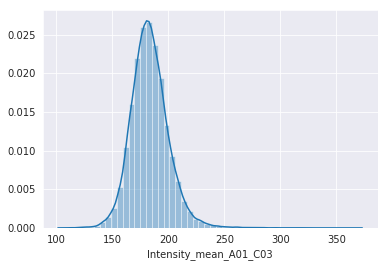

In [48]:
sea.distplot(fv10['Intensity_mean_A01_C03'])

The plot ink color can be specified with the additional parameter `color=`:

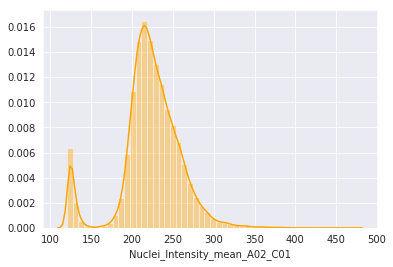

In [49]:
sea.distplot(fv10['Nuclei_Intensity_mean_A02_C01'], color='orange')

-----

## Scatter plots

Scatter plots are provided by [Seaborn function scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot).  The syntax of the `scatterplot()` function we are going to use is the following:
```
scatterplot(data=..., x=..., y=...)
```
where the named arguments have the following meaning:
- `data` is a table (PanDas `DataFrame`);
- `x` is the *name of a column* of `data` where to draw the x-axis values from;
- `y` is again the *name of a column* where to draw the y-axis values from.

Alternatively, you can just provide the `x` and `y` values as Python lists or NumPy arrays:
```
scatterplot(x=..., y=...)
```

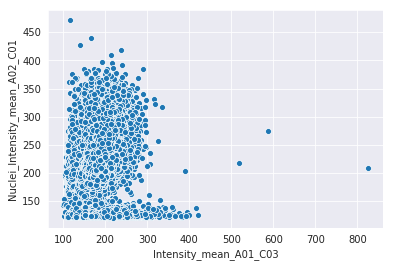

In [50]:
sea.scatterplot(data=all, x='Intensity_mean_A01_C03', y='Nuclei_Intensity_mean_A02_C01')

----

## Make a grid of plots

To arrange a number of plots in a grid, function [`plt.subplots`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) is used again:

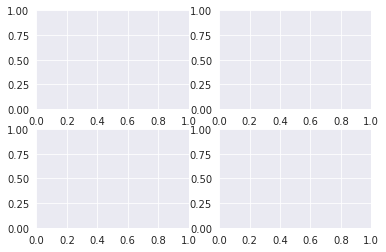

In [51]:
fig, axes = plt.subplots(2, 2)

Note that, when multiple plots are requested, the second return value from `plt.subplots` is an *array* (with the shape indicated in the numerical parameters to `plt.subplots`) -- so we must extract individual canvases ("axes") to draw a plot on them:

In [52]:
ul = axes[0,0]  # upper-left
ur = axes[0,1]  # upper-right
ll = axes[1,0]  # lower-left
lr = axes[1,1]  # lower-right

All Seaborn plotting functions accept an additional `ax=...` argument to plot on a specific canvas:

In [53]:
# well D07
sea.distplot(fvs[0]['Intensity_mean_A01_C03'], ax=ul)
sea.scatterplot(data=fvs[0], x='Nuclei_Intensity_mean_A02_C01', y='Intensity_mean_A01_C03', ax=ur)

# well D07
sea.distplot(fvs[1]['Intensity_mean_A01_C03'], ax=ll)
sea.scatterplot(data=fvs[1], x='Nuclei_Intensity_mean_A02_C01', y='Intensity_mean_A01_C03', ax=lr)

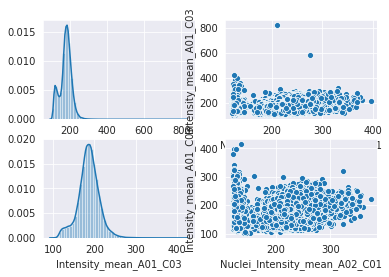

In [54]:
fig

-----

## Box plots

Box plots are provided by [Seaborn function boxplot()](https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot).  The syntax of the `boxplot()` function we are going to use is the following:
```
boxplot(data=..., x=..., y=..., hue=...)
```
where the named arguments have the following meaning:
- `data` is a table (PanDas `DataFrame`)
- `x` is the *name of a column* of `data` where to draw the x-axis values from; this should be a categorical variable.
- `y` is again the *name of a column* whose distribution detemines the parameters of the box and handles; `y` should name a continuous variable.

The following are optional:
- `hue` is again the *name of a column* of `data` (carrying a categorical variable): if supplied, for each value of `x`, a box+handles of a different color ("hue") will be drawn for each value of `hue`. In other words, by supplying `hue` you can make boxplots of 3D-data `(x,y,hue)`.
- `ax` used for placing a plot on a specific "subplot"

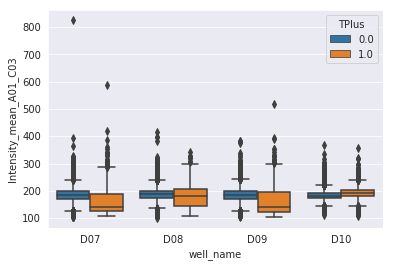

In [55]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(1, 1)

sea.boxplot(data=all, x='well_name', hue='TPlus', y='Intensity_mean_A01_C03', ax=ax)

-----

## Exercise 8.J.

Make a 2x2 grid of plots, showing box plots of the mean Intensity of the *Yap* channel for each of the wells D07, D08, D09, D10.

-----

## Violin plots

Violin plots are provided by [Seaborn function violinplot()](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot).  Producing a (useful) violin plot requires specifying quite some parameters; the syntax of the `violinplot()` function we are going to use is the following:
```
violinplot(data=..., x=..., y=..., hue=..., split=..., inner=...)
```
where the named arguments have the following meaning:
- `data` is a table (PanDas `DataFrame`)
- `x` is the *name of a column* of `data` where to draw the x-axis values from; this should be a categorical variable.
- `y` is again the *name of a column* whose distribution will be plotted to make the countour of the "violins"; `y` should name a continuous variable.

The following are optional:
- `hue` is again the *name of a column* of `data` (carrying a categorical variable): if supplied, for each value of `x`, a violin of a different color ("hue") will be drawn for each value of `hue`. In other words, by supplying `hue` you can make violin plots of 3D-data `(x,y,hue)`.
- `split`: if `True` and `hue` is the name of a discrete variable with 2 values, then, for each `x`, each half of the violin plots the `y` values corresponding to the different `hue`.
- `inner`: can be one of:
  * `'quartiles'`: mark the quartiles of the distribution
  * `'box'` make a miniature box plot inside the violin
  * `'point'` mark each data point
  * `None`: no inner decoration of the "violins"

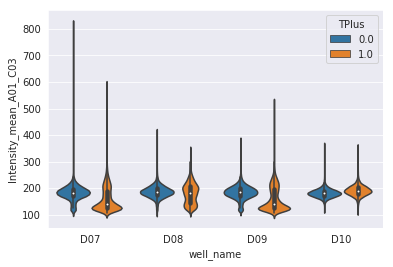

In [56]:
sea.violinplot(data=all, x='well_name', y='Intensity_mean_A01_C03', hue='TPlus')

-----

## Exercise 8.K

Modify the above violin plot so that only *one* (non-simmetrical) violin is shown per well: the two halves of the violin should show the distribution for TPlus-positive and TPlus-null data.

## Exercise 8.L

Make a 2x2 grid of the violin plots, showing only one well per plot.

-----